# Paradigma de posição livre

Esse tipo de formulação é mais simples, e as restrições servem para garantir que as caixas estejam dentro do container e que as caixas não se sobreponham.

Algo interessante é que os resultados indicam a existência de múltiplas soluções, em comparação com o artigo de referência. Maximizar usando o volume absoluto ou o relativo das caixas também causa resultados diferentes (no que concerne à disposição e quantidade de caixas colocadas), mantendo-se o mesmo valor de função objetivo.


## Volume absoluto

In [ ]:
import gurobipy as gp
from gurobipy import GRB

# Dados do contêiner
L, W, H = 12, 8, 8
M = 50  # Número grande o suficiente

# Dados das caixas (li, wi, hi)
boxes = [
    (6, 3, 2), (6, 3, 2),              # caixas 1-2
    (6, 4, 3), (6, 4, 3), (6, 4, 3),   # caixas 3-7
    (6, 4, 3), (6, 4, 3),
    (8, 3, 2), (8, 3, 2), (8, 3, 2),   # caixas 8-10
    (4, 3, 2), (4, 3, 2),              # caixas 11-12
    (4, 4, 3), (4, 4, 3), (4, 4, 3)    # caixas 13-15
]
m = len(boxes)

##################################
#         VOLUME ABSOLUTO        #
##################################
vi = [l*w*h for l,w,h in boxes]

model = gp.Model("container_absolute")

# Variáveis
p = model.addVars(m, vtype=GRB.BINARY, name="p")
x = model.addVars(m, vtype=GRB.CONTINUOUS, lb=0, name="x")
y = model.addVars(m, vtype=GRB.CONTINUOUS, lb=0, name="y")
z = model.addVars(m, vtype=GRB.CONTINUOUS, lb=0, name="z")

a = model.addVars(m, m, vtype=GRB.BINARY, name="a")
b = model.addVars(m, m, vtype=GRB.BINARY, name="b")
c = model.addVars(m, m, vtype=GRB.BINARY, name="c")
d = model.addVars(m, m, vtype=GRB.BINARY, name="d")
e = model.addVars(m, m, vtype=GRB.BINARY, name="e")
f = model.addVars(m, m, vtype=GRB.BINARY, name="f")

# Função objetivo
model.setObjective(gp.quicksum(vi[i] * p[i] for i in range(m)), GRB.MAXIMIZE)

# Restrições
# 1. Caixas dentro do container (eliminamos Xo, Yo, Zo)
for i in range(m):
    li, wi, hi = boxes[i]
    # Caixa dentro do container se p_i=1
    # obs se p_1 = 0, a desigualdade é sempre verdadeira pois M é um número grande
    model.addConstr(x[i] + li <= L + M * (1 - p[i]), f"bound_x_{i}")
    model.addConstr(y[i] + wi <= W + M * (1 - p[i]), f"bound_y_{i}")
    model.addConstr(z[i] + hi <= H + M * (1 - p[i]), f"bound_z_{i}")
            
    # Caixa automaticamente na posição (0, 0, 0) se p_i=0
    model.addConstr(x[i] <= M * p[i], f"pos_x_zero_{i}")
    model.addConstr(y[i] <= M * p[i], f"pos_y_zero_{i}")
    model.addConstr(z[i] <= M * p[i], f"pos_z_zero_{i}")

    for j in range(i + 1, m):
        lj, wj, hj = boxes[j]

        # 2. Não sobreposição
        model.addConstr((x[i] + li) <= (x[j] + (1 - a[i, j]) * M))
        model.addConstr((x[j] + lj) <= (x[i] + (1 - b[i, j]) * M))
        model.addConstr((y[i] + wi) <= (y[j] + (1 - c[i, j]) * M))
        model.addConstr((y[j] + wj) <= (y[i] + (1 - d[i, j]) * M))
        model.addConstr((z[i] + hi) <= (z[j] + (1 - e[i, j]) * M))
        model.addConstr((z[j] + hj) <= (z[i] + (1 - f[i, j]) * M))

        # Relação espacial por par
        model.addConstr(a[i, j] + b[i, j] + c[i, j] + d[i, j] + e[i, j] + f[i, j] >= p[i] + p[j] - 1)

# 3. Restrição para lidar com a simetria de caixas (por exemplo, se um problema tem 2 caixas 
# do mesmo tipo, a simples troca entre essas duas caixas não deveriam ser consideradas 
# soluções diferentes - e não queremos perder tempo achando elas)
# C. Symmetry-Breaking Constraints
box_groups = {}
for i, dims in enumerate(boxes):
    dim_key = tuple(dims)
    if dim_key not in box_groups:
        box_groups[dim_key] = []
    box_groups[dim_key].append(i)

for dims, indices in box_groups.items():
    if len(indices) > 1:
        for i_idx in range(len(indices) - 1):
            for j_idx in range(i_idx + 1, len(indices)):
                i = indices[i_idx]
                j = indices[j_idx]
                 # Se duas caixas iguais estiverem empacotadas, colocar uma ordem arbitrária
                model.addConstr(x[i] <= x[j] + M * (2 - p[i] - p[j]))

# Rodar o modelo
model.setParam('MIPGap', 0.123) 
model.optimize()


############################################
#              TXT                         #
############################################

# Criar mapeamento de tipos de caixa
tipo_dict = {}
tipo_counter = 1
for box in boxes:
    if box not in tipo_dict:
        tipo_dict[box] = tipo_counter
        tipo_counter += 1

# Imprimir saída no formato correto
print(f"{L} {W} {H}")  # primeira linha: dimensões do contêiner

for i in range(m):
    li, wi, hi = boxes[i]
    x_i = x[i].X if p[i].X > 0.5 else 0
    y_i = y[i].X if p[i].X > 0.5 else 0
    z_i = z[i].X if p[i].X > 0.5 else 0
    tipo = tipo_dict[boxes[i]]  # tipo real baseado nas dimensões
    cliente = 1
    print(f"{x_i} {y_i} {z_i} {li} {wi} {hi} {tipo} {cliente}")

with open('dados_freeloading_absoluto.txt','w') as f:
    f.write(f"{L} {W} {H}\n")  # primeira linha: dimensões do contêiner
    for i in range(m):
        if p[i].X > 0.5:
            li, wi, hi = boxes[i]
            x_i, y_i, z_i = x[i].X, y[i].X, z[i].X
            tipo = tipo_dict[boxes[i]]  # tipo baseado nas dimensões
            cliente = 1
            f.write(f"{x_i} {y_i} {z_i} {li} {wi} {hi} {tipo} {cliente}\n")
            
############################################
#              IMPRIMIR                    #
############################################
print("\n" + "="*40)
print("OPTIMAL SOLUTION FOUND")
print("="*40)

packed_volume = model.ObjVal
container_volume = L * W * H
utilization = (packed_volume / container_volume) * 100
            
print(f"Total volume of packed boxes: {packed_volume}")
print(f"Container volume utilization: {utilization:.2f}%\n")

packed_boxes_indices = sorted([i for i in range(m) if p[i].X > 0.5])
unpacked_boxes_indices = sorted([i for i in range(m) if p[i].X < 0.5])

print(f"Packed {len(packed_boxes_indices)} of {m} boxes.")
print("-" * 30)
aux = 0
for i in packed_boxes_indices:
    aux += vi[i]
    print(f"Box {i+1:<2}: Dims {str(boxes[i]):<10} | Packed at (x={x[i].X:.1f}, y={y[i].X:.1f}, z={z[i].X:.1f})")

if unpacked_boxes_indices:
    print("\nUnpacked boxes (indices):")
    print([i + 1 for i in unpacked_boxes_indices])



Set parameter MIPGap to value 0.123
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
MIPGap  0.123

Optimize a model with 843 rows, 1410 columns and 2982 nonzeros
Model fingerprint: 0x4e76c581
Variable types: 45 continuous, 1365 integer (1365 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [2e+01, 7e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 36.0000000
Presolve removed 104 rows and 779 columns
Presolve time: 0.01s
Presolved: 739 rows, 631 columns, 2649 nonzeros
Variable types: 45 continuous, 586 integer (586 binary)

Root relaxation: objective 7.680000e+02, 220 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd

### Resultado

Container volume utilization: 89.06%

Packed 13 of 15 boxes.

------------------------------


Box 1 : Dims (6, 3, 2)  | Packed at (x=0.0, y=5.0, z=6.0)

Box 3 : Dims (6, 4, 3)  | Packed at (x=0.0, y=0.0, z=5.0)

Box 4 : Dims (6, 4, 3)  | Packed at (x=0.0, y=4.0, z=0.0)

Box 5 : Dims (6, 4, 3)  | Packed at (x=6.0, y=0.0, z=5.0)

Box 6 : Dims (6, 4, 3)  | Packed at (x=6.0, y=4.0, z=5.0)

Box 7 : Dims (6, 4, 3)  | Packed at (x=6.0, y=4.0, z=0.0)

Box 8 : Dims (8, 3, 2)  | Packed at (x=4.0, y=5.0, z=3.0)

Box 9 : Dims (8, 3, 2)  | Packed at (x=4.0, y=0.0, z=0.0)

Box 11: Dims (4, 3, 2)  | Packed at (x=0.0, y=0.0, z=3.0)


Box 12: Dims (4, 3, 2)  | Packed at (x=0.0, y=5.0, z=3.0)

Box 13: Dims (4, 4, 3)  | Packed at (x=0.0, y=0.0, z=0.0)

Box 14: Dims (4, 4, 3)  | Packed at (x=4.0, y=0.0, z=2.0)

Box 15: Dims (4, 4, 3)  | Packed at (x=8.0, y=0.0, z=2.0)


Unpacked boxes (indices):
[2, 10]

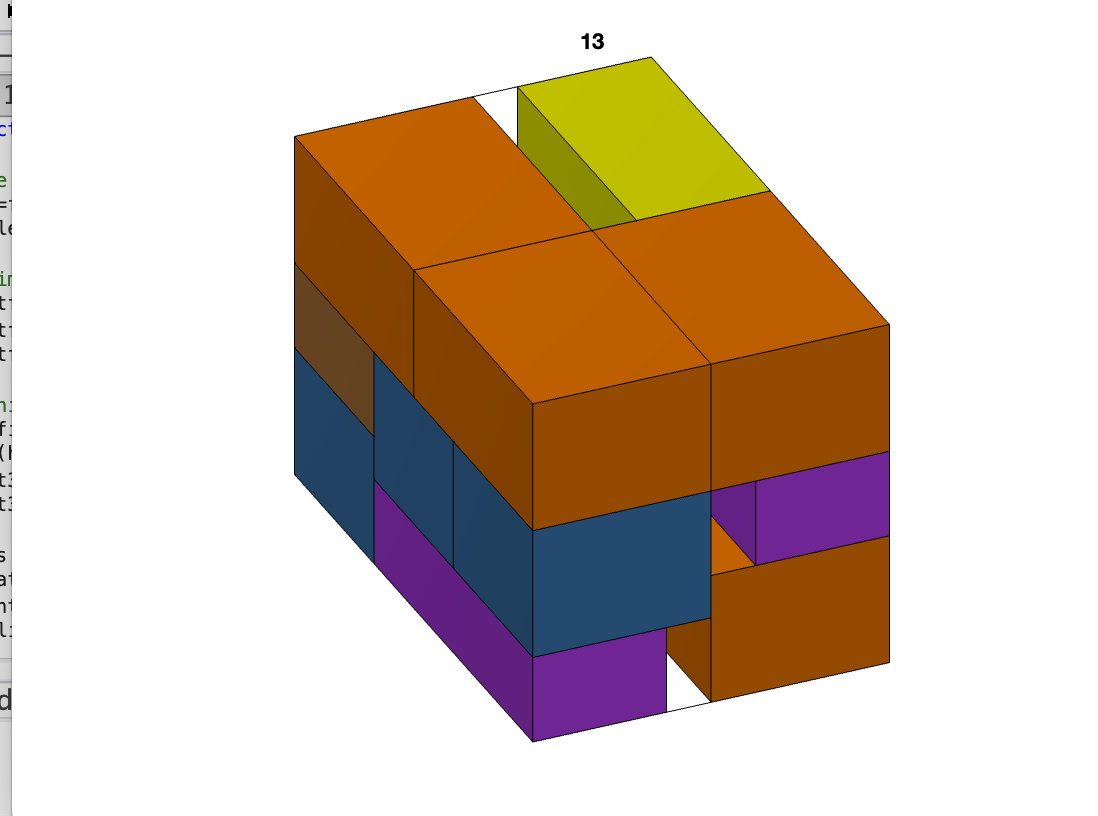

In [16]:
import gurobipy as gp
from gurobipy import GRB

def escrever_solucao_em_arquivo(model, p, x, y, z, boxes_dims, L, W, H, tipo_dict, filename):
    """
    Escreve o layout da solução final em um arquivo de texto.

    Formato do Arquivo:
    - Linha 1: L W H
    - Linhas seguintes: x y z l w h tipo cliente (para cada caixa empacotada)
    """
    print(f"\n--- Escrevendo solução no arquivo '{filename}'... ---")
    try:
        with open(filename, 'w') as f:
            # Escreve a primeira linha com as dimensões do contêiner
            f.write(f"{L} {W} {H}\n")
            
            # Itera por todas as caixas para verificar quais foram empacotadas
            m = len(boxes_dims)
            for i in range(m):
                # Apenas escreve no arquivo se a caixa foi de fato incluída na solução
                if p[i].X > 0.5:
                    li, wi, hi = boxes_dims[i]
                    x_i, y_i, z_i = x[i].X, y[i].X, z[i].X
                    tipo = tipo_dict[boxes_dims[i]]
                    cliente = 1  # Cliente fixo como 1, conforme solicitado
                    
                    # Escreve a linha formatada para a caixa
                    f.write(f"{x_i:.4f} {y_i:.4f} {z_i:.4f} {li} {wi} {hi} {tipo} {cliente}\n")
        
        print("Arquivo de solução salvo com sucesso.")
    except Exception as e:
        print(f"ERRO: Não foi possível escrever no arquivo de solução. Causa: {e}")


def executar_e_relatar(model, p, x, y, z, boxes_dims, L, W, H, tipo_dict, time_limit_seconds, output_filename):
    """
    Executa um modelo Gurobi, relata os resultados e salva a solução em um arquivo.
    """
    model.setParam('TimeLimit', time_limit_seconds)
    model.setParam('OutputFlag', 0)

    print(f"--- Executando modelo com limite de tempo de {time_limit_seconds} segundos... ---")
    
    model.optimize()

    print("\n" + "="*45)
    print("      RELATÓRIO FINAL DE EXECUÇÃO")
    print("="*45)

    if model.SolCount > 0:
        status_solucao = "Ótima" if model.status == GRB.OPTIMAL else "Subótima (Limite de Tempo Atingido)"
        
        print(f"Status da Solução: {status_solucao}")
        print(f"Valor Final Atingido (FO): {model.ObjVal:.4f}")
        print(f"Gap de Otimalidade: {model.MIPGap * 100:.4f}%")
        print(f"Tempo Computacional Despendido: {model.Runtime:.4f} segundos")
        
        # Chama a função para escrever a solução em um arquivo
        escrever_solucao_em_arquivo(model, p, x, y, z, boxes_dims, L, W, H, tipo_dict, output_filename)
    else:
        print("Status da Solução: Nenhuma solução viável foi encontrada.")
        print(f"Tempo Computacional Despendido: {model.Runtime:.4f} segundos")

    print("="*45 + "\n")




## Volume relativo

In [ ]:
import gurobipy as gp
from gurobipy import GRB

# Dados do contêiner
L, W, H = 12, 8, 8
M = 50  # Número grande o suficiente

# Dados das caixas (li, wi, hi)
boxes = [
    (6, 3, 2), (6, 3, 2),              # caixas 1-2
    (6, 4, 3), (6, 4, 3), (6, 4, 3),   # caixas 3-7
    (6, 4, 3), (6, 4, 3),
    (8, 3, 2), (8, 3, 2), (8, 3, 2),   # caixas 8-10
    (4, 3, 2), (4, 3, 2),              # caixas 11-12
    (4, 4, 3), (4, 4, 3), (4, 4, 3)    # caixas 13-15
]
m = len(boxes)

##################################
#         VOLUME RELATIVO       #
##################################
vi = [l*w*h/(L*W*H) for l,w,h in boxes]

model = gp.Model("container_absolute")

# Variáveis
p = model.addVars(m, vtype=GRB.BINARY, name="p")
x = model.addVars(m, vtype=GRB.CONTINUOUS, lb=0, name="x")
y = model.addVars(m, vtype=GRB.CONTINUOUS, lb=0, name="y")
z = model.addVars(m, vtype=GRB.CONTINUOUS, lb=0, name="z")

a = model.addVars(m, m, vtype=GRB.BINARY, name="a")
b = model.addVars(m, m, vtype=GRB.BINARY, name="b")
c = model.addVars(m, m, vtype=GRB.BINARY, name="c")
d = model.addVars(m, m, vtype=GRB.BINARY, name="d")
e = model.addVars(m, m, vtype=GRB.BINARY, name="e")
f = model.addVars(m, m, vtype=GRB.BINARY, name="f")

# Função objetivo
model.setObjective(gp.quicksum(vi[i] * p[i] for i in range(m)), GRB.MAXIMIZE)

# Restrições
# 1. Caixas dentro do container (eliminamos Xo, Yo, Zo)
for i in range(m):
    li, wi, hi = boxes[i]
    # Caixa dentro do container se p_i=1
    # obs se p_1 = 0, a desigualdade é sempre verdadeira pois M é um número grande
    model.addConstr(x[i] + li <= L + M * (1 - p[i]), f"bound_x_{i}")
    model.addConstr(y[i] + wi <= W + M * (1 - p[i]), f"bound_y_{i}")
    model.addConstr(z[i] + hi <= H + M * (1 - p[i]), f"bound_z_{i}")
            
    # Caixa automaticamente na posição (0, 0, 0) se p_i=0
    model.addConstr(x[i] <= M * p[i], f"pos_x_zero_{i}")
    model.addConstr(y[i] <= M * p[i], f"pos_y_zero_{i}")
    model.addConstr(z[i] <= M * p[i], f"pos_z_zero_{i}")

    for j in range(i + 1, m):
        lj, wj, hj = boxes[j]

        # 2. Não sobreposição
        model.addConstr((x[i] + li) <= (x[j] + (1 - a[i, j]) * M))
        model.addConstr((x[j] + lj) <= (x[i] + (1 - b[i, j]) * M))
        model.addConstr((y[i] + wi) <= (y[j] + (1 - c[i, j]) * M))
        model.addConstr((y[j] + wj) <= (y[i] + (1 - d[i, j]) * M))
        model.addConstr((z[i] + hi) <= (z[j] + (1 - e[i, j]) * M))
        model.addConstr((z[j] + hj) <= (z[i] + (1 - f[i, j]) * M))

        # Relação espacial por par
        model.addConstr(a[i, j] + b[i, j] + c[i, j] + d[i, j] + e[i, j] + f[i, j] >= p[i] + p[j] - 1)

# 3. Restrição para lidar com a simetria de caixas (por exemplo, se um problema tem 2 caixas 
# do mesmo tipo, a simples troca entre essas duas caixas não deveriam ser consideradas 
# soluções diferentes - e não queremos perder tempo achando elas)
# C. Symmetry-Breaking Constraints
box_groups = {}
for i, dims in enumerate(boxes):
    dim_key = tuple(dims)
    if dim_key not in box_groups:
        box_groups[dim_key] = []
    box_groups[dim_key].append(i)

for dims, indices in box_groups.items():
    if len(indices) > 1:
        for i_idx in range(len(indices) - 1):
            for j_idx in range(i_idx + 1, len(indices)):
                i = indices[i_idx]
                j = indices[j_idx]
                 # Se duas caixas iguais estiverem empacotadas, colocar uma ordem arbitrária
                model.addConstr(x[i] <= x[j] + M * (2 - p[i] - p[j]))

tipo_dict = {}
tipo_counter = 1
for box in boxes:
    if box not in tipo_dict:
        tipo_dict[box] = tipo_counter
        tipo_counter += 1
# Rodar o modelo
executar_e_relatar(
    model=model,
    p=p, x=x, y=y, z=z,
    boxes_dims=boxes,
    L=L, W=W, H=H,
    tipo_dict=tipo_dict,
    time_limit_seconds=3600,
    output_filename="solucao_freeloading.txt"
)
'''
model.setParam('MIPGap', 0.123) 
model.optimize()


############################################
#              TXT                         #
############################################

# Criar mapeamento de tipos de caixa
tipo_dict = {}
tipo_counter = 1
for box in boxes:
    if box not in tipo_dict:
        tipo_dict[box] = tipo_counter
        tipo_counter += 1

# Imprimir saída no formato correto
print(f"{L} {W} {H}")  # primeira linha: dimensões do contêiner

for i in range(m):
    li, wi, hi = boxes[i]
    x_i = x[i].X if p[i].X > 0.5 else 0
    y_i = y[i].X if p[i].X > 0.5 else 0
    z_i = z[i].X if p[i].X > 0.5 else 0
    tipo = tipo_dict[boxes[i]]  # tipo real baseado nas dimensões
    cliente = 1
    print(f"{x_i} {y_i} {z_i} {li} {wi} {hi} {tipo} {cliente}")

with open('dados_freeloading_relativo.txt','w') as f:
    f.write(f"{L} {W} {H}\n")  # primeira linha: dimensões do contêiner
    for i in range(m):
        if p[i].X > 0.5:
            li, wi, hi = boxes[i]
            x_i, y_i, z_i = x[i].X, y[i].X, z[i].X
            tipo = tipo_dict[boxes[i]]  # tipo baseado nas dimensões
            cliente = 1
            f.write(f"{x_i} {y_i} {z_i} {li} {wi} {hi} {tipo} {cliente}\n")
            
############################################
#              IMPRIMIR                    #
############################################
print("\n" + "="*40)
print("OPTIMAL SOLUTION FOUND")
print("="*40)

utilization = (model.ObjVal) * 100

print(f"Container volume utilization: {utilization:.2f}%\n")

packed_boxes_indices = sorted([i for i in range(m) if p[i].X > 0.5])
unpacked_boxes_indices = sorted([i for i in range(m) if p[i].X < 0.5])

print(f"Packed {len(packed_boxes_indices)} of {m} boxes.")
print("-" * 30)
aux = 0
for i in packed_boxes_indices:
    aux += vi[i]
    print(f"Box {i+1:<2}: Dims {str(boxes[i]):<10} | Packed at (x={x[i].X:.1f}, y={y[i].X:.1f}, z={z[i].X:.1f})")

if unpacked_boxes_indices:
    print("\nUnpacked boxes (indices):")
    print([i + 1 for i in unpacked_boxes_indices])

print("\n" + "="*40)


'''

Set parameter TimeLimit to value 3600
--- Executando modelo com limite de tempo de 3600 segundos... ---

      RELATÓRIO FINAL DE EXECUÇÃO
Status da Solução: Subótima (Limite de Tempo Atingido)
Valor Final Atingido (FO): 0.8906
Gap de Otimalidade: 12.2807%
Tempo Computacional Despendido: 3600.0066 segundos

--- Escrevendo solução no arquivo 'solucao_freeloading.txt'... ---
Arquivo de solução salvo com sucesso.



'\nmodel.setParam(\'MIPGap\', 0.123) \nmodel.optimize()\n\n\n############################################\n#              TXT                         #\n############################################\n\n# Criar mapeamento de tipos de caixa\ntipo_dict = {}\ntipo_counter = 1\nfor box in boxes:\n    if box not in tipo_dict:\n        tipo_dict[box] = tipo_counter\n        tipo_counter += 1\n\n# Imprimir saída no formato correto\nprint(f"{L} {W} {H}")  # primeira linha: dimensões do contêiner\n\nfor i in range(m):\n    li, wi, hi = boxes[i]\n    x_i = x[i].X if p[i].X > 0.5 else 0\n    y_i = y[i].X if p[i].X > 0.5 else 0\n    z_i = z[i].X if p[i].X > 0.5 else 0\n    tipo = tipo_dict[boxes[i]]  # tipo real baseado nas dimensões\n    cliente = 1\n    print(f"{x_i} {y_i} {z_i} {li} {wi} {hi} {tipo} {cliente}")\n\nwith open(\'dados_freeloading_relativo.txt\',\'w\') as f:\n    f.write(f"{L} {W} {H}\n")  # primeira linha: dimensões do contêiner\n    for i in range(m):\n        if p[i].X > 0.5:\n   

### Resultado

========================================

OPTIMAL SOLUTION FOUND

========================================

Container volume utilization: 89.06%

Packed 13 of 15 boxes.

------------------------------


Box 1 : Dims (6, 3, 2)  | Packed at (x=0.0, y=5.0, z=3.0)

Box 3 : Dims (6, 4, 3)  | Packed at (x=0.0, y=0.0, z=2.0)

Box 4 : Dims (6, 4, 3)  | Packed at (x=0.0, y=4.0, z=5.0)

Box 5 : Dims (6, 4, 3)  | Packed at (x=6.0, y=4.0, z=2.0)

Box 6 : Dims (6, 4, 3)  | Packed at (x=6.0, y=0.0, z=2.0)

Box 7 : Dims (6, 4, 3)  | Packed at (x=6.0, y=4.0, z=5.0)

Box 8 : Dims (8, 3, 2)  | Packed at (x=0.0, y=4.0, z=0.0)

Box 10: Dims (8, 3, 2)  | Packed at (x=0.0, y=0.0, z=0.0)

Box 11: Dims (4, 3, 2)  | Packed at (x=8.0, y=4.0, z=0.0)

Box 12: Dims (4, 3, 2)  | Packed at (x=8.0, y=0.0, z=0.0)

Box 13: Dims (4, 4, 3)  | Packed at (x=0.0, y=0.0, z=5.0)

Box 14: Dims (4, 4, 3)  | Packed at (x=4.0, y=0.0, z=5.0)

Box 15: Dims (4, 4, 3)  | Packed at (x=8.0, y=0.0, z=5.0)


Unpacked boxes (indices):
[2, 9]

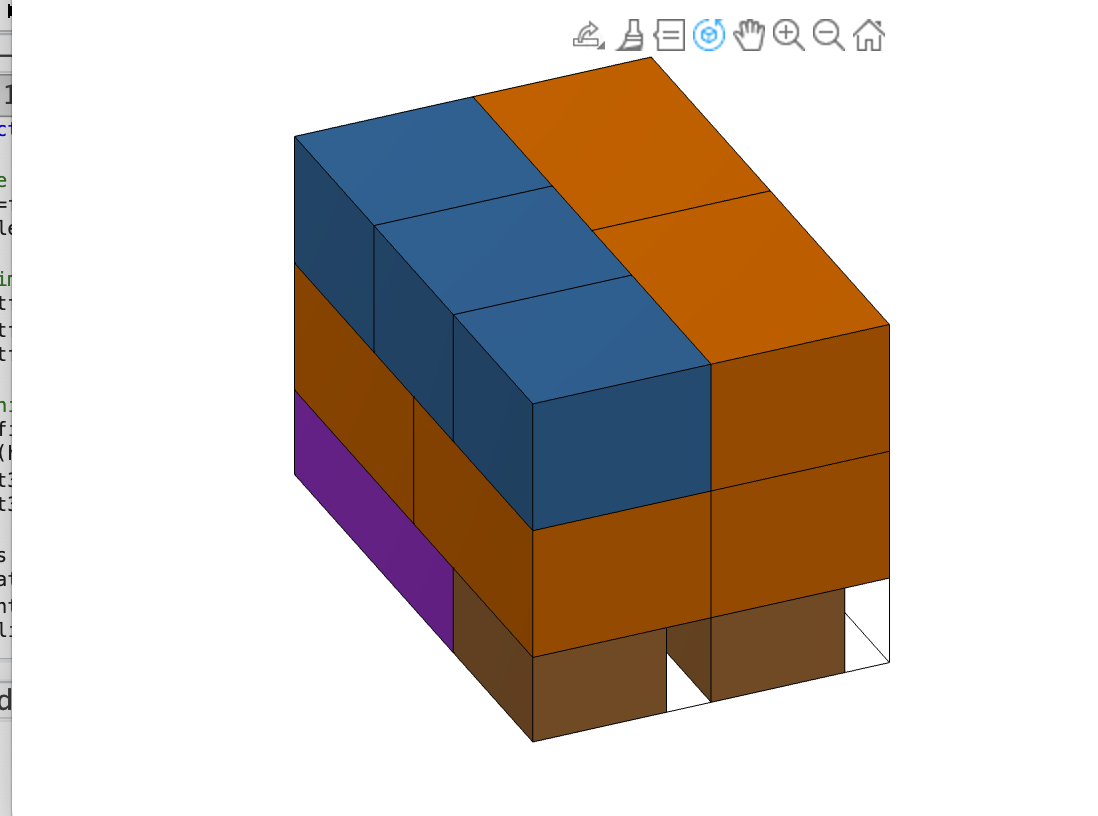